In [48]:
import cv2
import numpy as np
from pathlib import Path
import torch

from ultralytics import YOLO
import base64
import requests
from PIL import Image, ImageDraw, ImageFont

# tracker = DeepOCSORT(
#     model_weights=Path('osnet_x0_25_msmt17.pt'), # which ReID model to use
#     device='cuda:0',
#     fp16=True,
# )

color = (255, 255, 255)  # BGR
thickness = 2
fontscale = 0.5



def plot_one_box(x, img, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def is_inside_quadrilateral(point, quadrilateral_vertices):
    # Check if a point is inside a quadrilateral using the winding number algorithm.
    # `point` is a tuple (x, y), and `quadrilateral_vertices` is a list of tuples [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].

    x, y = point
    vertices = quadrilateral_vertices

    ok = 0


    x1, y1 = vertices[0]
    x2, y2 = vertices[1]

    if x >= x1 and y >= y1 and x < x2 and y < y2:
        return True
    
def count_bounding_boxes_in_quadrilateral(bounding_boxes, quadrilateral_vertices):
    count = 0
    for box in bounding_boxes:
        center_x = (box[0] + box[2]) / 2  # X-coordinate of the center
        center_y = (box[1] + box[3]) / 2  # Y-coordinate of the center
        center_point = (center_x, center_y)

        if is_inside_quadrilateral(center_point, quadrilateral_vertices):
            count += 1

    return count

# Example usage:
quadrilateral_vertices1 = [(542, 338), (890, 715)]
quadrilateral_vertices2 = [(1134, 499), (1301, 743)]
count1 = 0
count2 = 0
def calculate_iou(box1, box2):
    # box1 và box2 là danh sách [left, top, right, bottom]
    left1, top1, right1, bottom1 = box1
    left2, top2, right2, bottom2 = box2
    
    # Tính diện tích của cả hai bounding boxes
    area1 = (right1 - left1) * (bottom1 - top1)
    area2 = (right2 - left2) * (bottom2 - top2)

    # Tính diện tích của phần giao nhau giữa hai bounding boxes
    x_intersection = max(0, min(right1, right2) - max(left1, left2))
    y_intersection = max(0, min(bottom1, bottom2) - max(top1, top2))
    intersection_area = x_intersection * y_intersection

    # Tính IoU
    iou = intersection_area / (area1 + area2 - intersection_area)
    return iou

dict = {}

model = YOLO("best.pt")
model_detect_person = YOLO("detect_person.pt")
import time
cap = cv2.VideoCapture("rtsp://admin:@192.168.0.189:554")
cnt = 0
while(True):
    # time.sleep(1)
    cnt+=1
    if not(cnt%60 == 0):
        continue
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.resize(frame,(1920,1080))

    # results = model(frame, save=True, imgsz=960,  classes=0)[0]  # predict on an image
    # print("boxs:",results)

    # t1 = results.boxes.xyxy
    # t2 = results.boxes.conf
    # t3 = results.boxes.cls

    results = model(frame, imgsz=960)[0]

    # detect person
    results_person = model_detect_person(frame, save=True, imgsz=640,  classes=0)[0]


    for i in range(len(results.boxes.xyxy)):
        plot_one_box(results.boxes.xyxy[i], frame, color=(255,0,0), label=f'{results.boxes.conf[i]:.2f}')

    image1 = np.ones((1080, 1800, 3), dtype=np.uint8) * 255  # Màu trắng1

    ok1 = 0
    for i in range(len(results_person.boxes.xyxy)):
        if calculate_iou(results_person.boxes.xyxy[i],[542, 338, 890, 715]) > 0.2:
            ok1 = 1
    if ok1 == 0:
        count1 = count_bounding_boxes_in_quadrilateral(results.boxes.xyxy,quadrilateral_vertices1)
    else:
        count1 = count1
    plot_one_box([542, 338, 890, 715], frame, color=(0,0,0), label=f'hung')

    ok2 = 0
    for i in range(len(results_person.boxes.xyxy)):
        plot_one_box(results_person.boxes.xyxy[i], frame, color=(255,0,0), label=f'{results.boxes.conf[i]:.2f}')
        if calculate_iou(results_person.boxes.xyxy[i],[1134, 499, 1301, 743]) > 0.2:
            ok2 = 1
    if ok2 == 0:
        count2 = count_bounding_boxes_in_quadrilateral(results.boxes.xyxy,quadrilateral_vertices2)
    else:
        count2 = count2
    plot_one_box([1134, 499, 1301, 743], frame, color=(0,0,0), label=f'hung')

    # Thêm thông tin vào ảnh
    cv2.putText(image1, f"linh_kien1 : {count1}", (50, 500), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 0, 0), thickness=5, lineType=cv2.LINE_AA)
    cv2.putText(image1, f"linh_kien2 : {count2}", (50, 600), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 0, 0), thickness=5, lineType=cv2.LINE_AA)

    # Tạo hình vuông màu trắng 300x300
    image2 = frame

    # Ghép hai hình ảnh theo chiều ngang để tạo image3
    image3 = np.hstack((image2,image1))


    frame = image3
    frame = cv2.resize(frame,(1280,720))

    cv2.imshow('preview',frame)

    
    # Waits for a user input to quit the application
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# When everything done, release the capture
# out.release()
cap.release()
cv2.destroyAllWindows()


0: 544x960 4 0s, 340.0ms
Speed: 3.0ms preprocess, 340.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 960)

0: 384x640 2 persons, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict14

0: 544x960 4 0s, 313.0ms
Speed: 3.0ms preprocess, 313.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 960)

0: 384x640 1 person, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict14

0: 544x960 4 0s, 293.0ms
Speed: 2.0ms preprocess, 293.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 960)

0: 384x640 1 person, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict14

0: 544x960 4 0s, 291.0ms
Speed: 2.0ms preprocess, 291.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 960)

0: 384x

In [3]:
color = (0, 0, 255)  # BGR
thickness = 2
fontscale = 0.5

frame = cv2.imread("1.jpeg")

model = YOLO("best.pt")

In [4]:
frame.shape

(918, 1651, 3)

In [5]:
results = model(frame, imgsz=960)[0]


0: 544x960 4 0s, 307.0ms
Speed: 3.0ms preprocess, 307.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 960)


In [6]:
results.boxes.xyxy[0]

tensor([424.6735, 549.3858, 517.1003, 637.5541])

In [11]:
def plot_one_box(x, img, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)


In [11]:
plot_one_box(results.boxes.xyxy[0], frame, color=(255,0,0), label=f'{results.boxes.conf[0]:.2f}')

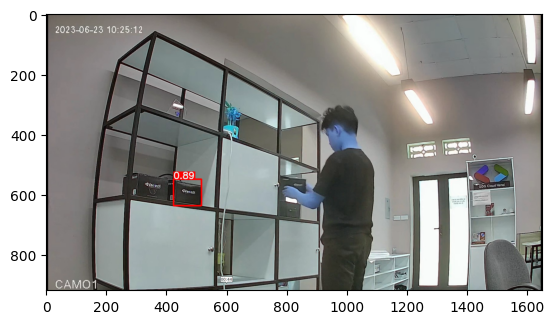

In [12]:
import matplotlib.pyplot as plt

# show image cv2 with matplotlib
plt.imshow(frame)
plt.show()